In [1]:
from poloniex import Poloniex
from tusp import string2ts, ts2string
import json
import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline

polo = Poloniex()

# historyData es una lista de diccionarios python
# candlestick period in seconds; valid values are 300, 900, 1800, 7200, 14400, and 86400
historyData = polo.returnChartData(currencyPair="BTC_XRP",
                     start=string2ts("2017-06-01 00:00:00"),
                     end=string2ts("2017-06-02 00:00:00"),
                     period=900)

# Guardando los datos como lista de diccionarios en un archivo de texto
# esto permite acceder a ellos y trabajar como data frame offline
with open("XMR_data.out","w") as f:
    json.dump(historyData,f)
    
with open("XMR_data.out") as f:
    historyData = json.load(f)
    #print data

# convirtiendo datos en data frame
df = pd.DataFrame(historyData)

#  convirtiendo string a float o int
df["close"] =pd.to_numeric(df['close'])
df["open"] =pd.to_numeric(df['open'])
df["low"] =pd.to_numeric(df['high'])
df["volume"] =pd.to_numeric(df['volume'])
df["date"] = pd.to_datetime(df["date"].apply(ts2string))

# seleccionando la columna de fecha como indice
df = df.set_index("date")

# examinando las primeras filas
df.head()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2017-06-01 00:00:00,0.000122,0.00012364,0.000124,0.000123,6000441.3884816,730.986556,0.00012182
2017-06-01 00:15:00,0.000119,0.000122,0.000122,0.000122,7275980.6333403,876.771651,0.0001205
2017-06-01 00:30:00,0.000119,0.00012068,0.000121,0.000119,9115569.643097,1079.706267,0.00011844
2017-06-01 00:45:00,0.000121,0.0001219,0.000122,0.000120,5289304.0213083,635.461814,0.00012014
2017-06-01 01:00:00,0.000119,0.00012092,0.000121,0.000121,4350547.704296,514.354155,0.00011822


# Calculando retornos, log retornos y sus respectivos acumulados

Retorno final del mercado: 7.62962962963


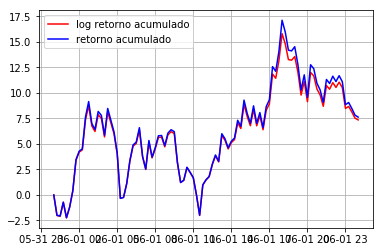

In [2]:
# Calculando retornos relativos
# el 1 se refiere al numero de periodos que se toma para calcular el cambio porcentual
df["retornos relativos"] = df["close"].pct_change(1).fillna(0)

# calculando los log retornos
df["log retornos"] = np.log(df["close"]).diff().fillna(0)

# calculando log retorno acumulado
df["cum_logr"] = df["log retornos"].cumsum()
df["cum_r"] = np.exp(df["cum_logr"]) - 1

plt.plot(df.index,df['cum_logr']*100,'r',label='log retorno acumulado')
plt.plot(df.index,df['cum_r']*100,'b', label='retorno acumulado')
plt.legend()
plt.grid()
#df.isnull().any()
#df[df['retornos relativos'].isnull()]
print "Retorno final del mercado: %s"%(df["cum_r"][-1]*100)

# Ejemplo estrategía, media movil

Las estrategías funcionan como funciones que como parámetro reciben una serie de pandas o una lista de tamaño $T$ (intervalo de tiempo de estudio divido en el periodo de interés), y devuelven el vector de pesos $\vec{w}$ de tamaño $T\times 2$ y que contiene solo ceros o unos (1 si se posee el determinado activo, 0 si no). La primera columna de $\vec{w}$ corresponde a la posesión del activo de interés, la segunda a la posesión de la moneda por la que se tranza (generalmente **BTC**) 

El retorno relativo con la estrategia EMA5 VS SMA20 fue: 17.9753851274
                       w orders     price
date                                     
2017-06-01 00:15:00  1.0    BUY  0.000119
2017-06-01 01:00:00  0.0   SELL  0.000119
2017-06-01 01:15:00  1.0    BUY  0.000120
2017-06-01 05:00:00  0.0   SELL  0.000126
2017-06-01 06:45:00  1.0    BUY  0.000130
2017-06-01 07:15:00  0.0   SELL  0.000125
2017-06-01 07:30:00  1.0    BUY  0.000128
2017-06-01 09:45:00  0.0   SELL  0.000125
2017-06-01 12:45:00  1.0    BUY  0.000126
2017-06-01 19:45:00  0.0   SELL  0.000136
2017-06-01 22:30:00  1.0    BUY  0.000136
2017-06-01 23:00:00  0.0   SELL  0.000132


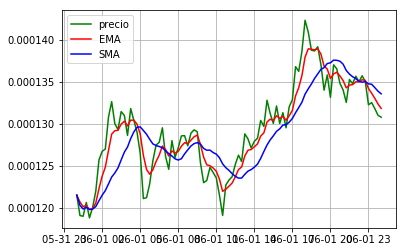

In [19]:
from profit import profit,change5
from orders import orders

# dada una serie de pandas o una lista y el numero de muestras para la EMA y SMA devuelve vector w
# considerando el cruce entre EMA y SMA
def estrategiaEMAvsSMA(serie, smaPeriod=13,emaPeriod=5):
    
    # Calculando media movil a 20 muestras
    sma = serie.rolling(smaPeriod,min_periods=1).mean()
    # caculando exponential movil average
    ema = serie.ewm(span=emaPeriod, adjust=False).mean()
    
    # Encontrando el signo de la resta entre ellas para encontrar los cruces
    dif = (ema - sma).apply(np.sign)
    
    w = pd.DataFrame(data={"w":(dif+1)/2})
    
    w['w'] = w['w'].apply(change5)
    
    w["orders"] = orders(w["w"])
    
    w["price"] = serie
    
    plt.plot(df.index,df['close'],'g',label='precio')
    plt.plot(df.index,ema,'r',label='EMA')
    plt.plot(df.index,sma,'b',label='SMA')
    plt.legend(loc='best')
    plt.grid()
    
    return w



w = estrategiaEMAvsSMA(df['close'])
relativeReturn, vecReturn = profit(w["w"],df["close"])

#plt.plot(df.index,vecReturn,'g',label='retorno')


print 'El retorno relativo con la estrategia EMA5 VS SMA20 fue: %s'%(relativeReturn*100)
print w[w["orders"] != "WAIT"]



## Probando otras versiones de la estrategia de cruce de medias

El mejor desempeño en las estrategias de medias moviles para el par XRP_BTC entre 1/06/2017 y el 1/09/2017 con precio de un día, lo obtuvo price vs EMA_5, con un profit de 239.78%. El mercado en cambio tuvo un profit de -62.77% en el mismo periodo.
<br>
***Intervalo precio, profit price vs EMA_5, profit market*** 
<br>
* 1d, 239.78%, -62.77%
* 4h, 2.937%, -53.9%
* 2h, 17.655.12%, -55.11%
* 30m, 12'202.905%, -49.58% 

In [17]:
from strategy import pricevsEMA, pricevsSMA, EMAvsEMA

#Precio vs EMA_5

w = pricevsEMA(df["close"])
relativeReturn,v = profit(w["w"],df["close"])


print 'El retorno relativo con la estrategia EMA5 VS SMA20 fue: %s'%(relativeReturn*100)

El retorno relativo con la estrategia EMA5 VS SMA20 fue: 66.21908348


El retorno relativo con la estrategia EMA5 VS SMA20 fue: 32.3705404237


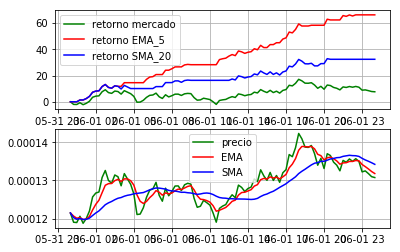

In [16]:
#Precio vs SMA_20

w2 = pricevsSMA(df["close"])
relativeReturn,v2 = profit(w2["w"],df["close"])

# Calculando media movil a 20 muestras
sma = df["close"].rolling(20,min_periods=1).mean()
# caculando exponential movil average
ema = df["close"].ewm(span=5, adjust=False).mean()

plt.subplot(211)
plt.plot(df.index,df['cum_r']*100,'g', label='retorno mercado')
plt.plot(df.index,v*100,'r',label='retorno EMA_5')
plt.plot(df.index,v2*100,'b',label='retorno SMA_20')
plt.legend(loc='best')
plt.grid()

plt.subplot(212)
plt.plot(df.index,df['close'],'g',label='precio')
plt.plot(df.index,ema,'r',label='EMA')
plt.plot(df.index,sma,'b',label='SMA')
plt.legend(loc='best')
plt.grid()


print 'El retorno relativo con la estrategia EMA5 VS SMA20 fue: %s'%(relativeReturn*100)

In [6]:
#EMA_5 vs EMA_20

w = EMAvsEMA(df["close"])
relativeReturn,v = profit(w["w"],df["close"])

print 'El retorno relativo con la estrategia EMA5 VS EMA20 fue: %s'%(relativeReturn*100)

El retorno relativo con la estrategia EMA5 VS EMA20 fue: 9.7741056737
